In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()

#Importing libraries required for the case study and to plot charts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from wordcloud import WordCloud

## **Data Loading**


---


The data is in JSON format and we need to convert it to a dataframe.

In [4]:
root_path = '/kaggle/input/automatic-ticket-classification-dataset/Automatic-Ticket-Classification-Dataset/complaints-2021-05-14_08_16.json'

In [5]:
# Opening JSON file 
f = open(root_path) 

# returns JSON object as a dictionary 
data = json.load(f)

## **Data preparation**


---

* Data cleaning operations like filtering text, removing missing values & renaming column headers.

In [6]:
df=pd.json_normalize(data)

In [7]:
# Inspect the dataframe to understand the given data.
df.head(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [9]:
#Assign new column names
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product',]]
df.head()

,_source.complaint_what_happened,_source.product,_source.sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [10]:
# lets rename the column names to be more read friendly
# we have retained product and sub_product only for verification purpose ,
# these columns will not be used in the Topic modelling
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})
df.head()

,complaint_text,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [11]:
# lets merge the category and sub-category this will help us in deciding the topics after NMF modelling
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)
df.head()

,complaint_text,category
0,,Debt collection+Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...
3,,Mortgage+Conventional home mortgage
4,,Credit card or prepaid card+General-purpose cr...


In [14]:
#Assign nan in place of blanks in the complaints column
# lets replace empty complain with nan value
df[df['complaint_text']==''] = np.nan
df.complaint_text.isnull().sum()

57241

## **Text Preprocessing**


---



### **Prepare the text for topic modeling**

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [16]:
# Write your function here to clean the text and remove all the unnecessary elements.
# Preparing text for Topic modelling
def clean_text(text):
    text = text.lower()  # Make the text lowercase
    text = re.sub('\[.*\]','', text).strip() # Remove text in square brackets
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub('\S*\d\S*\s*','', text).strip()  # Remove words containing numbers
    return text.strip()


In [17]:
df.complaint_text = df.complaint_text.apply(lambda x: clean_text(x))
df.complaint_text.head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in and was told b...
10    chase card was reported on however fraudulent ...
11    on while trying to book a xxxx  xxxx  ticket i...
14    my grand son give me check for i deposit it in...
Name: complaint_text, dtype: object

In [18]:
#Write your function to Lemmatize the texts
# lemmatization
#Function to Lemmatize the texts
stopwords = nlp.Defaults.stop_words
def lemmatizer(text):
    doc = nlp(text)
    sent = [token.lemma_ for token in doc if not token.text in set(stopwords)]
    return ' '.join(sent)

In [19]:
# Lemmatize the complaints
df['lemma'] =  df.complaint_text.apply(lambda x: lemmatizer(x))
df.head()

,complaint_text,category,lemma
1,good morning my name is xxxx xxxx and i apprec...,Debt collection+Credit card debt,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,Credit card or prepaid card+General-purpose cr...,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,"Credit reporting, credit repair services, or o...",chase card report fraudulent application submi...
11,on while trying to book a xxxx xxxx ticket i...,"Credit reporting, credit repair services, or o...",try book xxxx xxxx ticket come offer apply...
14,my grand son give me check for i deposit it in...,Checking or savings account+Checking account,grand son check deposit chase account fund cle...


In [20]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint_text','lemma','category']]
df_clean.head()

,complaint_text,lemma,category
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o..."
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o..."
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account


In [21]:
#Write your function to extract the POS tags NN
def extract_pos_tags(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(sent)
    

In [22]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['complaint_POS_removed'] =  df_clean.lemma.apply(lambda x: extract_pos_tags(x))
df_clean.head()

,complaint_text,lemma,category,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,agent anniversary date change agent informatio...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,account pay money son money money check owner ...


## **Exploratory data analysis (EDA)**


---



### **Exploratory data analysis to get familiar with the data.**

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




(array([9.671e+03, 6.253e+03, 2.602e+03, 1.204e+03, 6.870e+02, 2.520e+02,
        1.290e+02, 7.100e+01, 5.400e+01, 3.500e+01, 2.900e+01, 1.200e+01,
        1.700e+01, 7.000e+00, 1.200e+01, 4.000e+00, 5.000e+00, 3.000e+00,
        2.000e+00, 4.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([    0.  ,   232.26,   464.52,   696.78,   929.04,  1161.3 ,
         1393.56,  1625.82,  1858.08,  2090.34,  2322.6 ,  2554.86,
         2787.12,  3019.38,  3251.64,  3483.9 ,  3716.16,  3948.42,
         4180.68,  4412.94,  4645.2 ,  4877.46,  5109.72,  5341.98,
         5574.24,  5806.5 ,  6038.76,  6271.02,  6503.28,  6735.54,
         6967.8 ,  7200.06,  7432.32

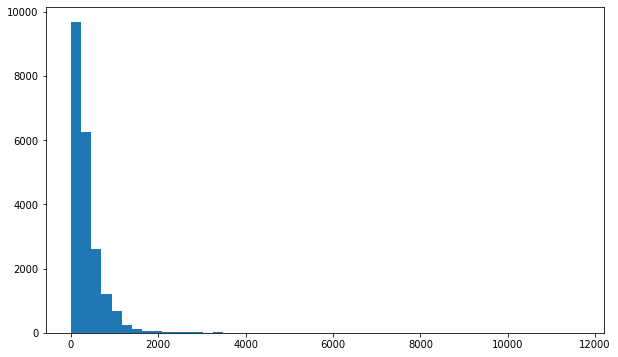

In [23]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)

#### **Find the top 40 words by frequency among all the articles after processing the text.**

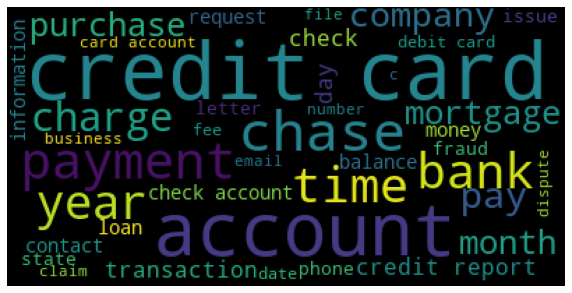

In [25]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(df_clean.complaint_POS_removed))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [26]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean = df_clean.drop(['complaint_POS_removed'],axis = 1)

#### **Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.**

In [27]:
# Write your code here to find the top 30 unigram,bigram,trigram frequency 
# among the complaints in the cleaned datafram(df_clean).

def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]


In [28]:
top_30_unigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=3, top=30)

In [29]:
#Print the top 10 words in the unigram frequency
print('Top 10 unigrams:\n')
top_30_unigrams[:10]

Top 10 unigrams:



[('account', 38141),
 ('credit', 31612),
 ('card', 29121),
 ('chase', 21532),
 ('payment', 20007),
 ('charge', 15653),
 ('time', 14205),
 ('bank', 11688),
 ('money', 11670),
 ('check', 11354)]

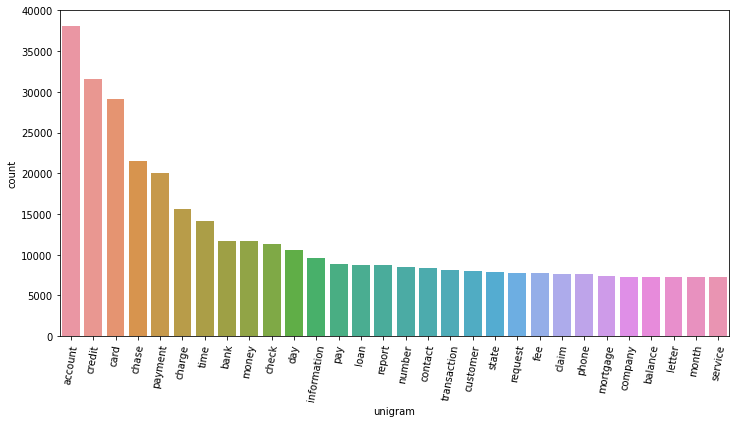

In [30]:
#Plot graph for the top 30 words in the unigram frequency
df1 = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df1['unigram'], y=df1['count'])
plt.xticks(rotation = 80)
plt.show()

In [31]:
#Print the top 10 words in the bigram frequency
print('Top 10 bigrams:\n')
top_30_bigrams[:10]

Top 10 bigrams:



[('credit card', 12318),
 ('credit report', 3250),
 ('customer service', 2897),
 ('check account', 2483),
 ('debit card', 1875),
 ('account account', 1688),
 ('card account', 1599),
 ('credit score', 1597),
 ('bank account', 1432),
 ('payment payment', 1314)]

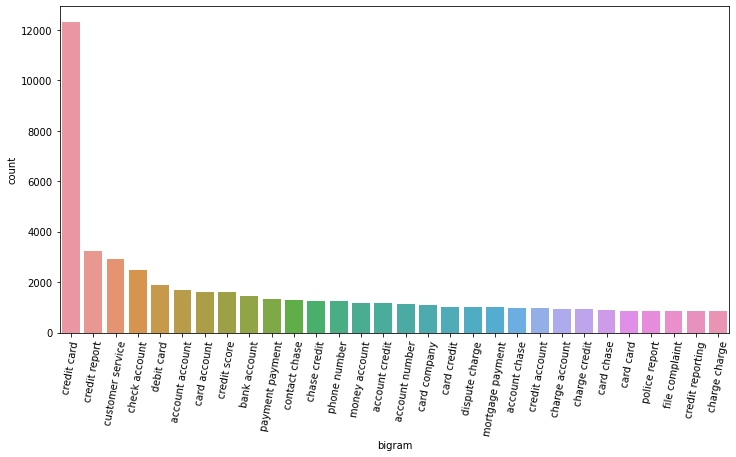

In [32]:
#Plot graph for the top 30 words in the bigram frequency
df2 = pd.DataFrame(top_30_bigrams, columns = ['bigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df2['bigram'], y=df2['count'])
plt.xticks(rotation = 80)
plt.show()

In [33]:
#Print the top 10 words in the trigram frequency
print('Top 10 trigrams:\n')
top_30_trigrams[:10]

Top 10 trigrams:



[('credit card account', 1038),
 ('credit card company', 980),
 ('chase credit card', 870),
 ('charge credit card', 583),
 ('credit card credit', 500),
 ('credit card chase', 449),
 ('inquiry credit report', 443),
 ('card credit card', 412),
 ('account credit card', 396),
 ('file police report', 356)]

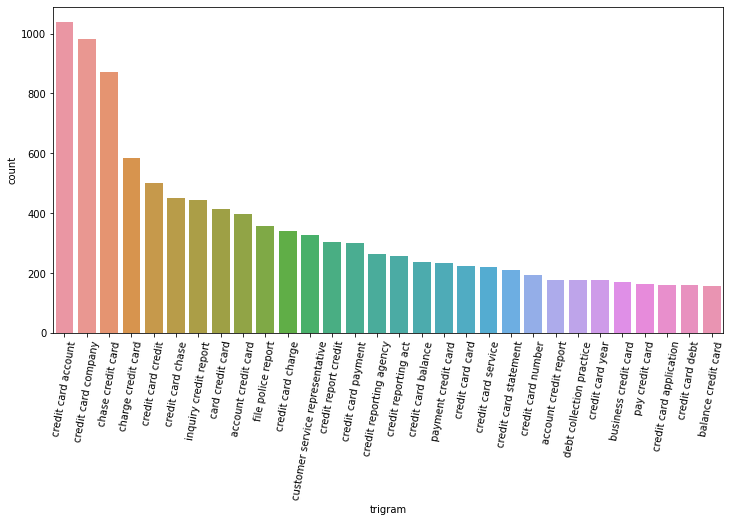

In [34]:
#Plot graph for the top 30 words in the trigram frequency
df3 = pd.DataFrame(top_30_trigrams, columns = ['trigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df3['trigram'], y=df3['count'])
plt.xticks(rotation = 80)
plt.show()

#### **The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis**

In [35]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [36]:
#All masked texts has been removed
df_clean.head()

,complaint_text,lemma,category,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,agent anniversary date change agent informatio...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,account pay money son money money check owner ...


## **Feature Extraction**

---


#### **Convert the raw texts to a matrix of TF-IDF features**

- **max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

- **min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [37]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### **Create a document term matrix using fit_transform**

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [38]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.Complaint_clean) 

In [39]:
tfidf.get_feature_names()[:10]

['aa',
 'aarp',
 'abandonment',
 'abatement',
 'abbreviation',
 'abd',
 'aberrant',
 'abhorrent',
 'abide',
 'ability']

In [40]:
len(tfidf.get_feature_names())

6141

## **Topic Modelling**

---



- ### **Topic Modelling using NMF**

- **Non-Negative Matrix Factorization (NMF)** is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

- In this task you have to perform the following:

 * Find the best number of clusters 
 * Apply the best number to create word clusters
 * Inspect & validate the correction of each cluster wrt the complaints 
 * Correct the labels if needed 
 * Map the clusters to topics/cluster names

In [41]:
from sklearn.decomposition import NMF

- ### **Manual Topic Modeling**
 - You need to do take the trial & error approach to find the best num of topics for your NMF model.

 - The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [42]:
#Load your nmf_model with the n_components i.e 5
num_topics =  5 

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_

In [44]:
#Print the Top15 words for each of the topics
num_words=15

vocab = np.array(tfidf.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [45]:
vocab

array(['aa', 'aarp', 'abandonment', ..., 'zombie', 'zone', 'zoom'],
      dtype='<U53')

In [46]:
topics

['account check money bank deposit fund branch day transfer number chase transaction business claim customer',
 'credit card report inquiry account chase score company information limit application debt letter year balance',
 'payment balance pay month statement fee day auto time date credit year chase error account',
 'charge dispute fee card transaction merchant purchase claim refund chase fraud service balance email statement',
 'loan mortgage home modification property document request rate chase foreclosure year time letter sale information']

In [47]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(df_clean.Complaint_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.01,0.01,0.01,0.01,0.03,4
Doc1,0.01,0.00,0.00,0.00,0.01,0
Doc2,0.00,0.06,0.00,0.00,0.00,1
Doc3,0.01,0.06,0.00,0.00,0.02,1
Doc4,0.07,0.00,0.00,0.00,0.00,0


In [48]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = significant_topic

In [49]:
pd.set_option('display.max_colwidth', -1)

In [51]:
# Print the first 10 Complaint for each of the Topics
temp =df_clean[['complaint_text','Complaint_clean','category','Topic']].groupby('Topic').head(10)
temp.sort_values('Topic')

,complaint_text,Complaint_clean,category,Topic
27,i opened an account with chase bank on xxxx and used a code for xxxx bonus i called to follow up on xxxxxxxx about the terms and was told everything was on the account and once i made xxxx direct deposit the bonus would be paid out in days as of xxxx i had made the required deposits and was told my account never had the coupon code applied and it was past the days to do so so no bonus would be paid,account deposit bonus pay deposit account coupon code day bonus,Checking or savings account+Checking account,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,agent anniversary date change agent information order account anniversary date consent recording agent,Credit card or prepaid card+General-purpose credit card or charge card,0
69,someone called stating i had felony committed under my social security number and name took xxxx out of my checking account to secure my assets stating from police department,state felony security number account asset state police department,Checking or savings account+Checking account,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,account pay money son money money check owner country time date check number number,Checking or savings account+Checking account,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has be

#### **After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:**
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [52]:
#Create the dictionary of Topic names and Topics
topic_mapping = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_mapping)

In [53]:
df_clean.head()

,complaint_text,lemma,category,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection+Credit card debt,morning help chase debt verification statement bank validate debt mail month attempt debt information consumer advance help,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,Credit card or prepaid card+General-purpose credit card or charge card,agent anniversary date change agent information order account anniversary date consent recording agent,Bank Account services
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports+Other personal consumer report",card report application submit identity consent service credit verify identity applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision immediately contact xxxx refer chase bank immediately contact chase bank get notification screen tell chase representative speak applicatio

#### **Lets check if there is any class imbalance**

<AxesSubplot:xlabel='Topic', ylabel='count'>

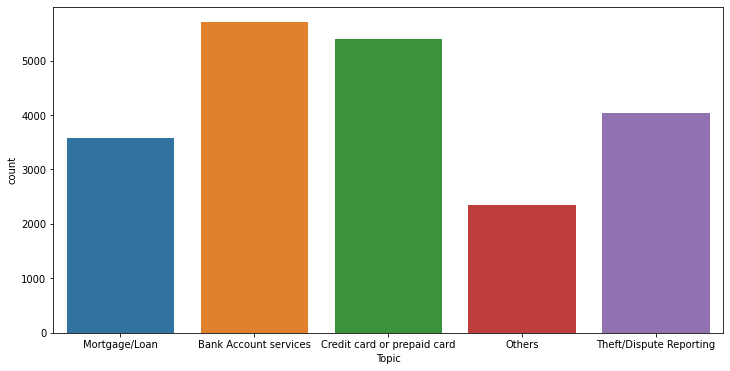

In [54]:
# Plot graph to check class imbalance
plt.figure(figsize=(12,6))
sns.countplot(x='Topic',data=df_clean)

## Prepare training data

In [55]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

training_data = df_clean[['complaint_text','Topic']]

In [56]:
training_data.head()

,complaint_text,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Bank Account services
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,Credit card or prepaid card
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,Bank Account services


In [57]:
## Reverse topic names mapping for supervised learning

reverse_topic_mapping = {
    'Bank Account services' :0,
    'Credit card or prepaid card':1,
    'Others':2,
    'Theft/Dispute Reporting':3,
    'Mortgage/Loan':4
}
#Replace Topics with Topic Names
training_data['Topic'] = training_data['Topic'].map(reverse_topic_mapping)
training_data.head()

,complaint_text,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,0
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,0


## Write data to csv file

In [ ]:
training_data.to_csv('training_data.csv')